In [1]:
# !pip uninstall -y numpy scipy statsmodels pmdarima


# !pip install numpy==1.25.2 scipy==1.11.4 statsmodels==0.14.0 pmdarima==2.0.4

# **1. Loading of files, checking assumptions and pre-processing steps**


================ Fengyun-2F.csv ================
Missing values in raw BMM: 0
Time step distribution (top 5):
timestamp
1 days 00:07:15.943296    2
1 days 04:08:10.112064    1
0 days 19:00:41.377248    1
0 days 23:29:32.899201    1
2 days 08:51:25.546751    1
Name: count, dtype: int64
IQR outlier removal skipped for this satellite.


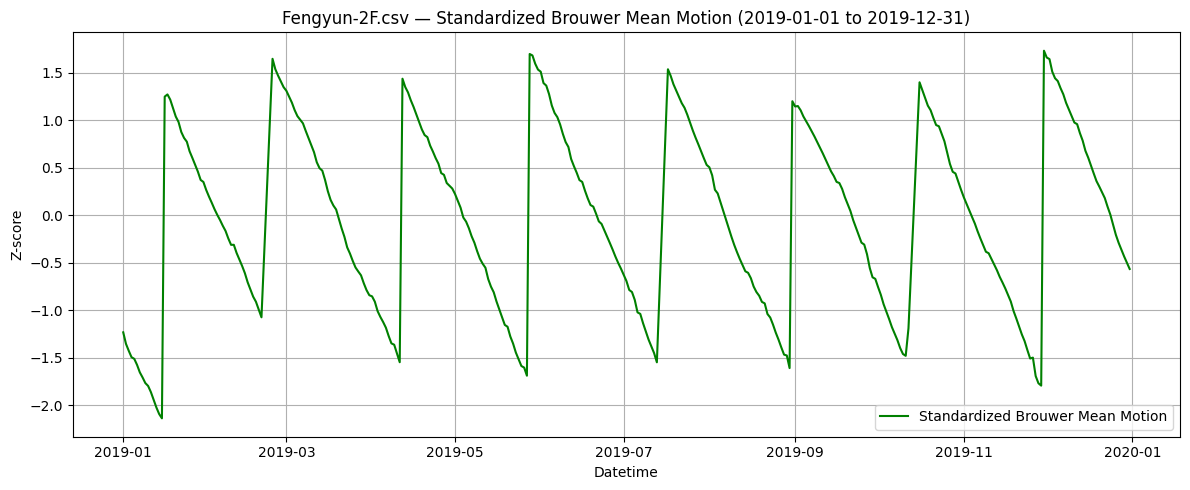

ADF on pre-standardization series:
  ADF Statistic: -18.720553
  p-value      : 2.03277e-30
  -> ✅ Stationary (p < 0.05)

Augmented Dickey–Fuller on standardized series:
  ADF Statistic      : -18.720553
  p-value            : 2.03277e-30
  # Lags Used        : 30
  # Observations Used: 3384
  Critical Values:
     1%: -3.432284
     5%: -2.862394
     10%: -2.567225
  -> ✅ Conclusion: Stationary (reject H₀)

================ Fengyun-2E.csv ================
Missing values in raw BMM: 0
Time step distribution (top 5):
timestamp
1 days 00:07:15.287520    1
0 days 11:09:14.065632    1
1 days 09:06:32.904864    1
1 days 06:17:58.266816    1
0 days 19:20:54.778849    1
Name: count, dtype: int64
IQR outlier removal applied with k=1.5 (kept 2750/2780).


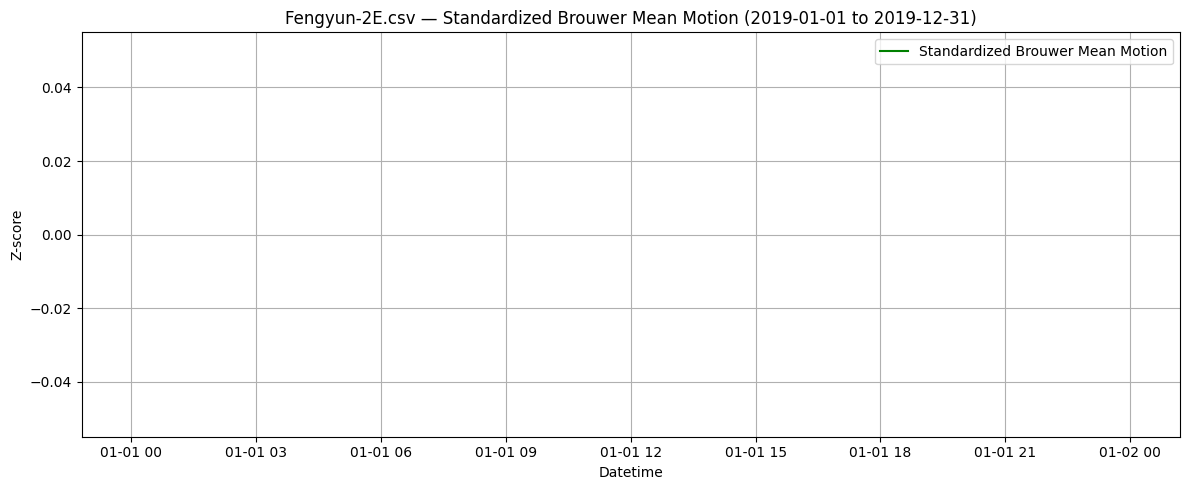

ADF on pre-standardization series:
  ADF Statistic: -13.570923
  p-value      : 2.21578e-25
  -> ✅ Stationary (p < 0.05)

Augmented Dickey–Fuller on standardized series:
  ADF Statistic      : -13.570923
  p-value            : 2.21578e-25
  # Lags Used        : 21
  # Observations Used: 2728
  Critical Values:
     1%: -3.432749
     5%: -2.862600
     10%: -2.567334
  -> ✅ Conclusion: Stationary (reject H₀)

================ Fengyun-2H.csv ================
Missing values in raw BMM: 0
Time step distribution (top 5):
timestamp
0 days 03:26:46.200192    2
1 days 00:07:07.720608    2
0 days 03:26:46.201921    2
1 days 00:07:15.856032    2
0 days 05:57:52.150464    1
Name: count, dtype: int64
IQR outlier removal skipped for this satellite.


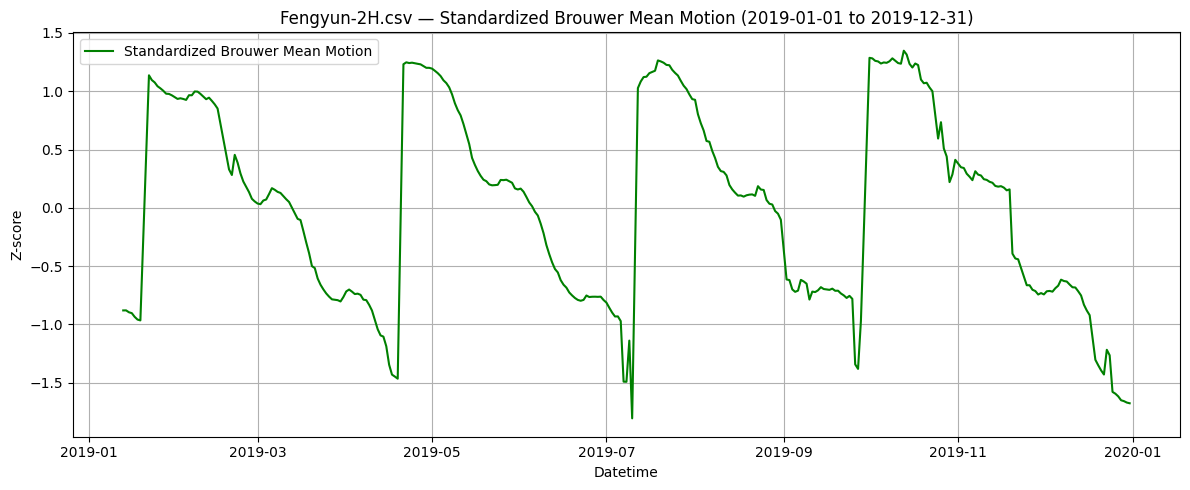

ADF on pre-standardization series:
  ADF Statistic: -5.878188
  p-value      : 3.12331e-07
  -> ✅ Stationary (p < 0.05)

Augmented Dickey–Fuller on standardized series:
  ADF Statistic      : -5.878188
  p-value            : 3.12331e-07
  # Lags Used        : 2
  # Observations Used: 1105
  Critical Values:
     1%: -3.436282
     5%: -2.864159
     10%: -2.568165
  -> ✅ Conclusion: Stationary (reject H₀)

================ Sentinel-3A.csv ================
Missing values in raw BMM: 0
Time step distribution (top 5):
timestamp
0 days 23:33:49.112352    9
0 days 23:33:49.119264    5
0 days 23:33:49.084704    5
0 days 23:33:49.169376    5
0 days 23:33:49.174560    5
Name: count, dtype: int64
IQR outlier removal skipped for this satellite.


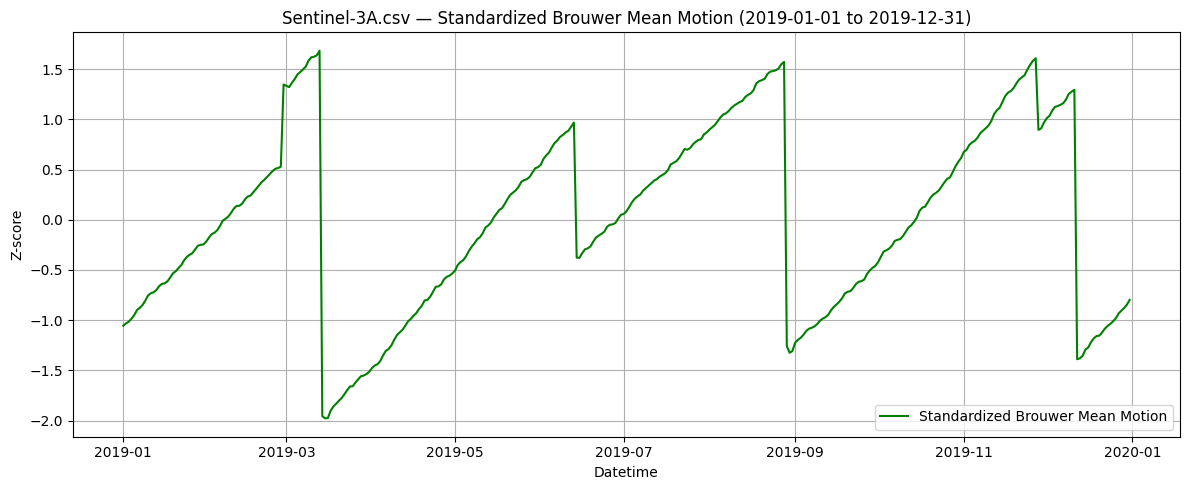

ADF on pre-standardization series:
  ADF Statistic: -9.169247
  p-value      : 2.41331e-15
  -> ✅ Stationary (p < 0.05)

Augmented Dickey–Fuller on standardized series:
  ADF Statistic      : -9.169247
  p-value            : 2.41331e-15
  # Lags Used        : 4
  # Observations Used: 2396
  Critical Values:
     1%: -3.433082
     5%: -2.862747
     10%: -2.567413
  -> ✅ Conclusion: Stationary (reject H₀)

================ SARAL.csv ================
Missing values in raw BMM: 0
Time step distribution (top 5):
timestamp
1 days 01:09:13.574592    2
1 days 07:51:22.839552    2
1 days 01:09:13.845889    2
1 days 01:09:13.938336    2
1 days 04:30:11.219040    2
Name: count, dtype: int64
IQR outlier removal applied with k=0.8 (kept 3472/3476).
First difference applied AFTER standardization (SARAL only).


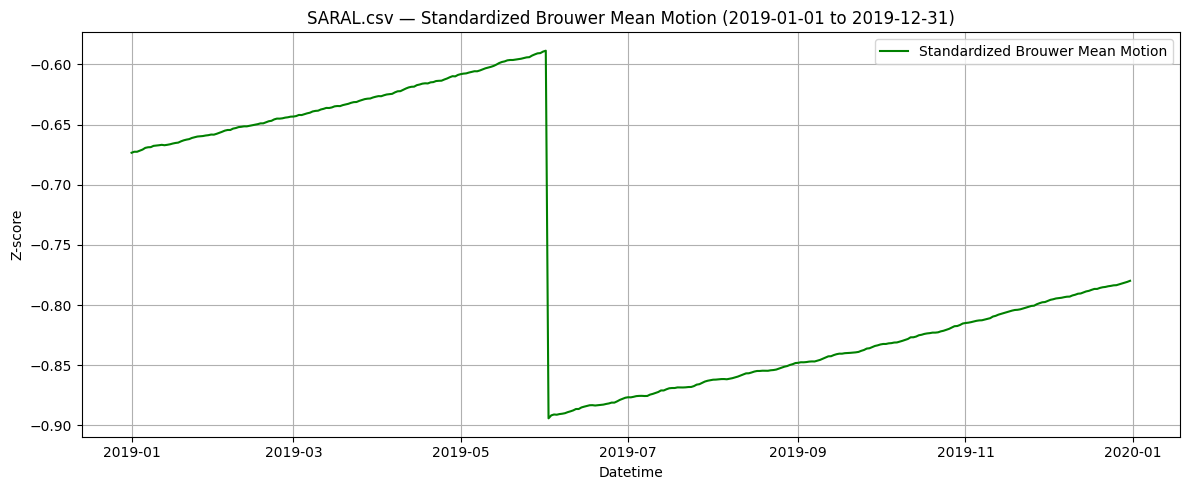

ADF on pre-standardization series:
  ADF Statistic: -1.660954
  p-value      : 0.451334
  -> ❌ Not stationary (p ≥ 0.05)

Augmented Dickey–Fuller on standardized series:
  ADF Statistic      : -1.660954
  p-value            : 0.451334
  # Lags Used        : 6
  # Observations Used: 3465
  Critical Values:
     1%: -3.432239
     5%: -2.862374
     10%: -2.567214
  -> ❌ Conclusion: Non-stationary (fail to reject H₀)

ADF on SARAL standardized+diff series:
  ADF Statistic: -26.936282, p-value: 0


In [2]:
# ==== Loop all satellites in /content, preprocess, plot, and run ADF tests ====
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Files already uploaded to /content
orbital_elements = ['Fengyun-2F.csv','Fengyun-2E.csv','Fengyun-2H.csv','Sentinel-3A.csv','SARAL.csv']
BASE = "/content"  # where you uploaded the files

# Fixed plot window
start_date = '2019-01-01'
end_date   = '2019-12-31'

# Store outputs for reuse
#   pre_std_series: interpolated (+ IQR for 2E & SARAL) BEFORE standardization
#   bmm_standardized: standardized z-score series
#   bmm_standardized_diff: ONLY for SARAL, standardized series differenced
preprocessed = {}  # {sat_name: {"pre_std_series": Series, "bmm_standardized": Series, "bmm_standardized_diff": Series|None}}

def preprocess_one_sat(csv_filename: str):
    sat_name = os.path.basename(csv_filename)
    csv_path = os.path.join(BASE, csv_filename)

    print(f"\n================ {sat_name} ================")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV not found at {csv_path}")

    # Load
    df = pd.read_csv(csv_path)

    # Parse timestamp and set index
    if 'Unnamed: 0' not in df.columns:
        raise KeyError(f"'Unnamed: 0' timestamp column not found in {sat_name}. Columns: {list(df.columns)}")
    if 'Brouwer mean motion' not in df.columns:
        raise KeyError(f"'Brouwer mean motion' column not found in {sat_name}. Columns: {list(df.columns)}")

    df['timestamp'] = pd.to_datetime(df['Unnamed: 0'])
    df = df.set_index('timestamp').sort_index()

    # Missing values & time-step distribution
    print(f"Missing values in raw BMM: {df['Brouwer mean motion'].isnull().sum()}")
    time_deltas = df.index.to_series().diff().value_counts()
    print("Time step distribution (top 5):")
    print(time_deltas.head())

    # Select BMM column
    bmm_series = df['Brouwer mean motion']

    # Resample to daily mean
    bmm_resampled = bmm_series.resample('D').mean()

    # Linear interpolation
    bmm_interpolated = bmm_resampled.interpolate(method='linear')

    # Start from interpolated as base (pre-standardization)
    series_pre_std = bmm_interpolated.copy()

    # IQR outlier removal:
    # - Fengyun-2E.csv -> k = 1.5
    # - SARAL.csv      -> k = 0.8  (your request)
    # - Others         -> no outlier removal
    if sat_name in ('Fengyun-2E.csv', 'SARAL.csv'):
        k = 1.5 if sat_name == 'Fengyun-2E.csv' else 0.8
        q1 = series_pre_std.quantile(0.25)
        q3 = series_pre_std.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        mask = (series_pre_std >= lower_bound) & (series_pre_std <= upper_bound)
        kept = int(mask.sum())
        total = len(series_pre_std)
        series_pre_std = series_pre_std[mask]
        print(f"IQR outlier removal applied with k={k} (kept {kept}/{total}).")
    else:
        print("IQR outlier removal skipped for this satellite.")

    # Standardize (Z-score) — baseline series for all satellites
    mu = series_pre_std.mean()
    sigma = series_pre_std.std()
    sigma = sigma if sigma != 0 else 1.0
    bmm_standardized = (series_pre_std - mu) / sigma

    # DIFFERENCING ONLY FOR SARAL — AFTER standardization
    bmm_standardized_diff = None
    if sat_name == 'SARAL.csv':
        bmm_standardized_diff = bmm_standardized.diff().dropna()
        print("First difference applied AFTER standardization (SARAL only).")

    # Plot standardized data for fixed window
    standardized_window = bmm_standardized.loc[start_date:end_date]
    plt.figure(figsize=(12, 5))
    plt.plot(standardized_window, label='Standardized Brouwer Mean Motion', color='green')
    plt.title(f'{sat_name} — Standardized Brouwer Mean Motion ({start_date} to {end_date})')
    plt.xlabel('Datetime'); plt.ylabel('Z-score'); plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    # ADF on pre-standardization series (interpolated + optional IQR; NO differencing)
    if series_pre_std.dropna().shape[0] > 10:
        result_prestd = adfuller(series_pre_std.dropna())
        print("ADF on pre-standardization series:")
        print(f"  ADF Statistic: {result_prestd[0]:.6f}")
        print(f"  p-value      : {result_prestd[1]:.6g}")
        print("  ->", "✅ Stationary (p < 0.05)" if result_prestd[1] < 0.05 else "❌ Not stationary (p ≥ 0.05)")
    else:
        print("ADF skipped on pre-standardization series (insufficient data).")

    # ADF on standardized series (non-differenced)
    if bmm_standardized.dropna().shape[0] > 10:
        adf_result = adfuller(bmm_standardized.dropna())
        print("\nAugmented Dickey–Fuller on standardized series:")
        print(f"  ADF Statistic      : {adf_result[0]:.6f}")
        print(f"  p-value            : {adf_result[1]:.6g}")
        print(f"  # Lags Used        : {adf_result[2]}")
        print(f"  # Observations Used: {adf_result[3]}")
        print("  Critical Values:")
        for key, value in adf_result[4].items():
            print(f"     {key}: {value:.6f}")
        alpha = 0.05
        print("  ->", "✅ Conclusion: Stationary (reject H₀)" if adf_result[1] < alpha else "❌ Conclusion: Non-stationary (fail to reject H₀)")
    else:
        print("ADF skipped on standardized series (insufficient data).")

    # (Optional) ADF on SARAL's standardized+diff series
    if sat_name == 'SARAL.csv' and bmm_standardized_diff is not None and bmm_standardized_diff.shape[0] > 10:
        adf_saral_diff = adfuller(bmm_standardized_diff.dropna())
        print("\nADF on SARAL standardized+diff series:")
        print(f"  ADF Statistic: {adf_saral_diff[0]:.6f}, p-value: {adf_saral_diff[1]:.6g}")

    return series_pre_std, bmm_standardized, bmm_standardized_diff

# Run for all satellites found in /content
for csv_file in orbital_elements:
    pre_std, std_series, std_series_diff = preprocess_one_sat(csv_file)
    preprocessed[os.path.basename(csv_file)] = {
        "pre_std_series": pre_std,                    # after (optional) IQR
        "bmm_standardized": std_series,               # standardized version
        "bmm_standardized_diff": std_series_diff      # ONLY for SARAL, else None
    }


In [3]:
!pip install pmdarima



🔧 Auto-ARIMA selection and diagnostics for: Fengyun-2F.csv
Using d=0 (assumed stationary).
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9692.350, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6656.135, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5230.504, Time=1.51 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4568.673, Time=1.06 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=4202.232, Time=1.51 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=3991.271, Time=1.85 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3751.252, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3669.202, Time=0.77 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3665.664, Time=0.99 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3663.300, Time=1.88 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=3659.396, Time=2.33 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3662.678, Time=0.63 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3501.168, Time=2.92 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3477.437

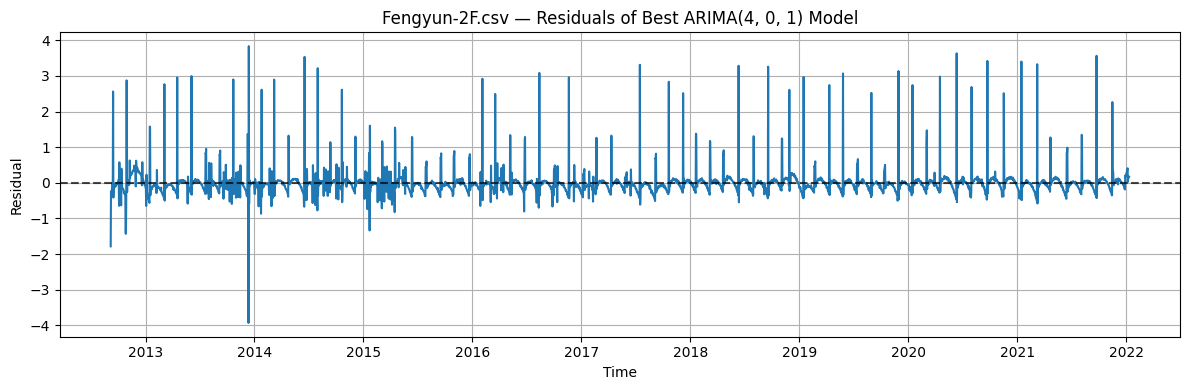

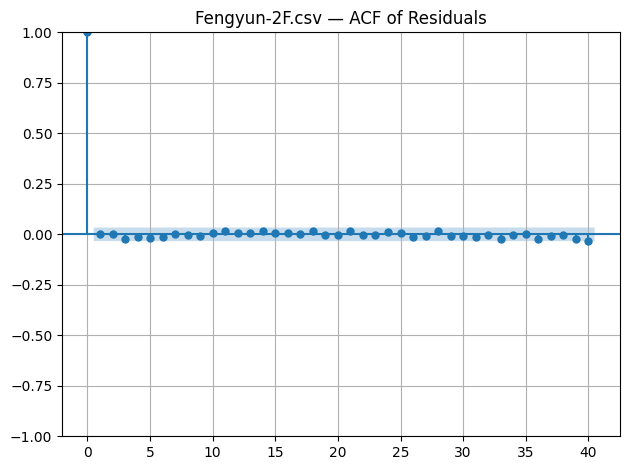

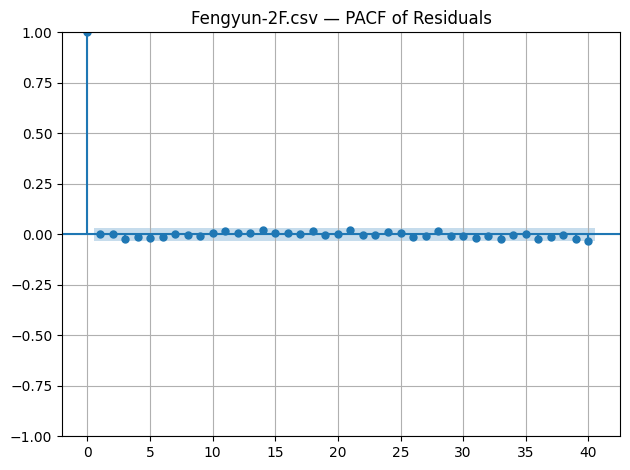

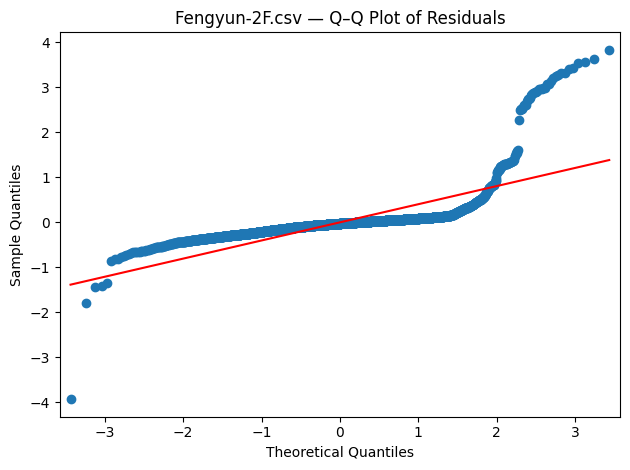


📊 Ljung–Box Test Results:
      lb_stat  lb_pvalue
10   3.977041   0.948377
20   7.273723   0.995686
30  11.648319   0.998948

✅ Conclusion: Residuals resemble white noise (no significant autocorrelation).

🔧 Auto-ARIMA selection and diagnostics for: Fengyun-2E.csv
Using d=0 (assumed stationary).
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7805.162, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5487.621, Time=0.20 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4416.513, Time=0.44 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3893.299, Time=0.54 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=3581.270, Time=0.71 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=3383.857, Time=1.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3090.272, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3085.405, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3084.387, Time=0.54 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3080.744, Time=0.53 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC

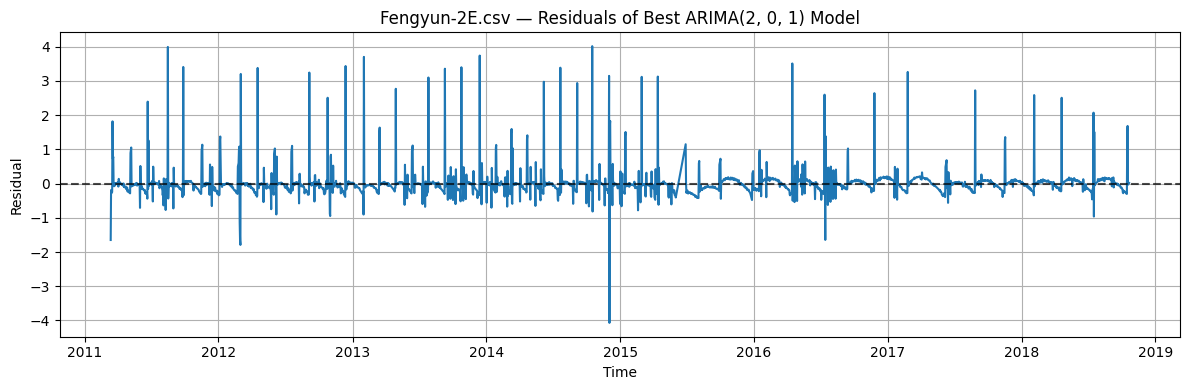

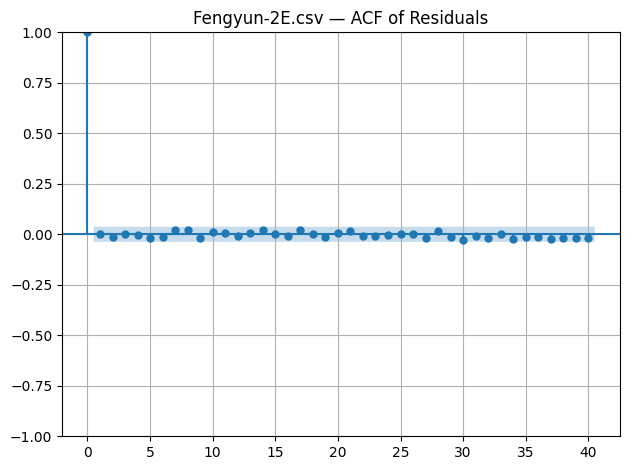

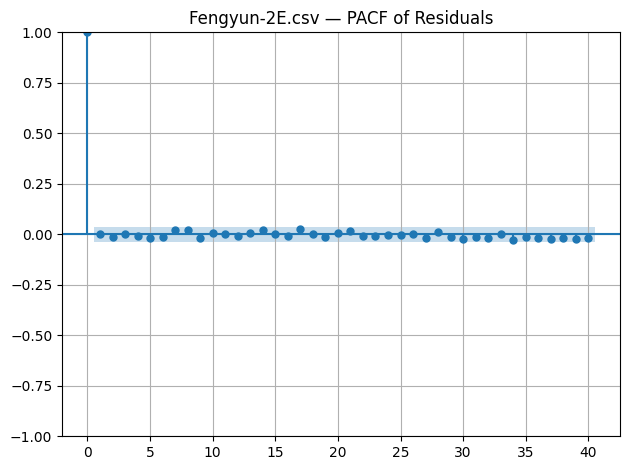

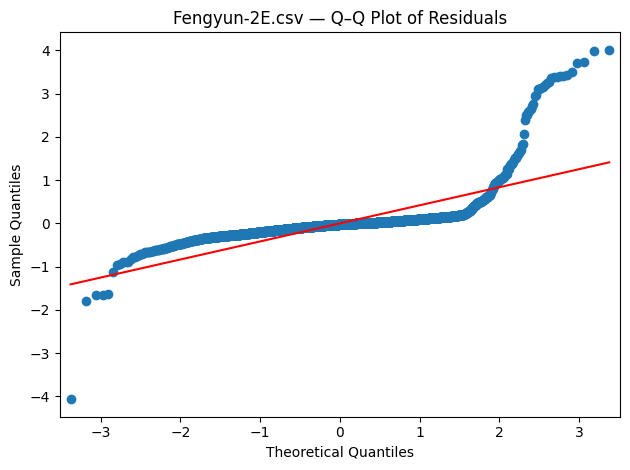


📊 Ljung–Box Test Results:
      lb_stat  lb_pvalue
10   5.286213   0.871257
20   9.451110   0.977069
30  14.808095   0.990780

✅ Conclusion: Residuals resemble white noise (no significant autocorrelation).

🔧 Auto-ARIMA selection and diagnostics for: Fengyun-2H.csv
Using d=0 (assumed stationary).
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3145.367, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2035.498, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1424.595, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1088.577, Time=0.24 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=870.995, Time=0.29 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=750.861, Time=0.57 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=482.727, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=474.470, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=470.173, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=469.347, Time=0.20 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=470.9

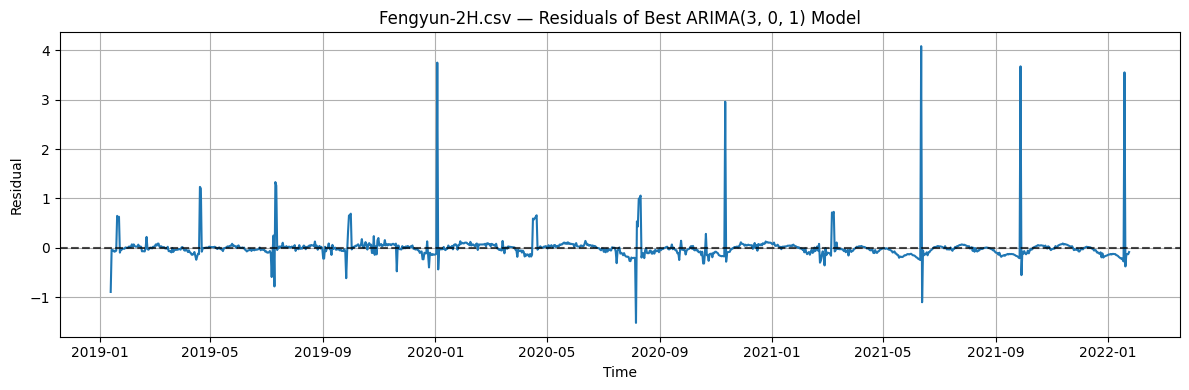

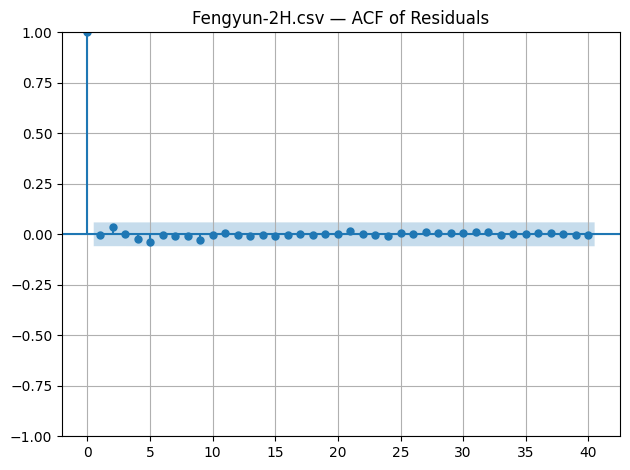

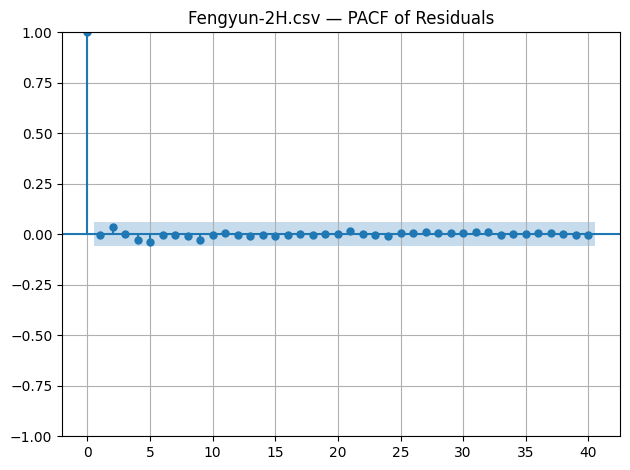

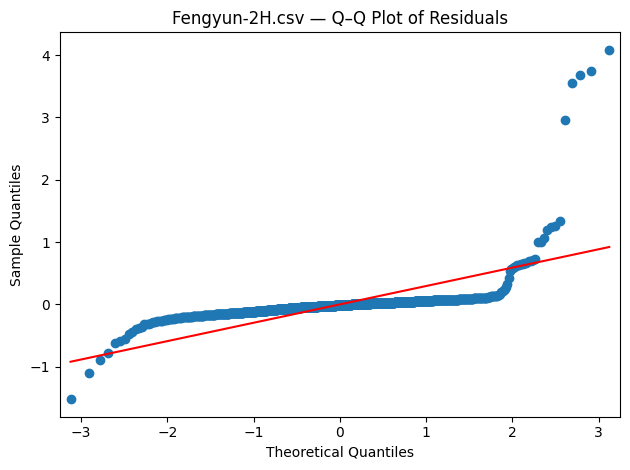


📊 Ljung–Box Test Results:
     lb_stat  lb_pvalue
10  4.776641   0.905590
20  4.960330   0.999739
30  5.640064   1.000000

✅ Conclusion: Residuals resemble white noise (no significant autocorrelation).

🔧 Auto-ARIMA selection and diagnostics for: Sentinel-3A.csv
Using d=0 (assumed stationary).
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6814.743, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4687.297, Time=0.54 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3614.429, Time=1.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3059.739, Time=0.54 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2797.401, Time=0.69 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=2619.656, Time=0.65 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2250.753, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2247.241, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2245.958, Time=0.23 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2244.115, Time=0.45 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=22

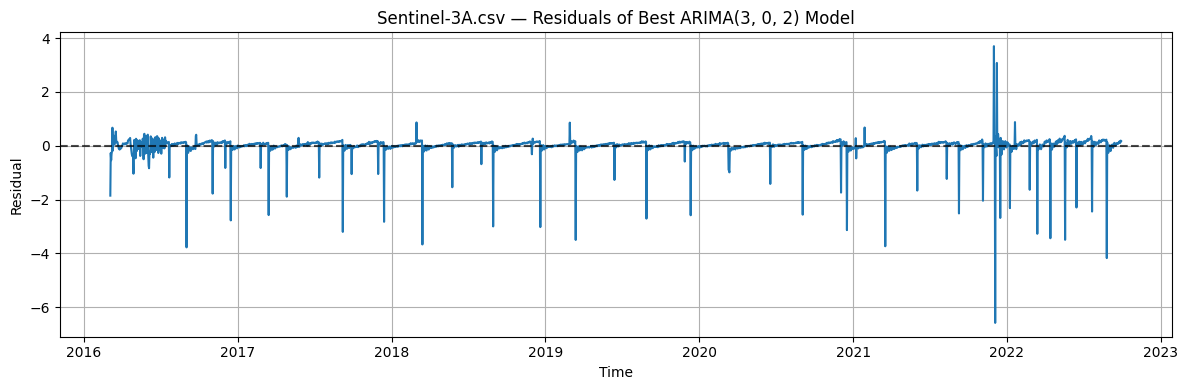

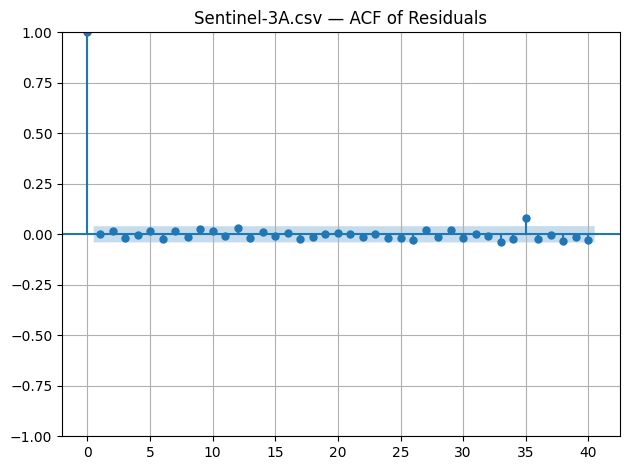

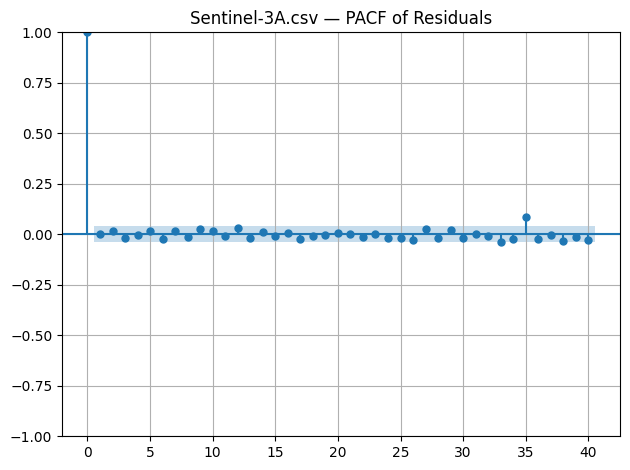

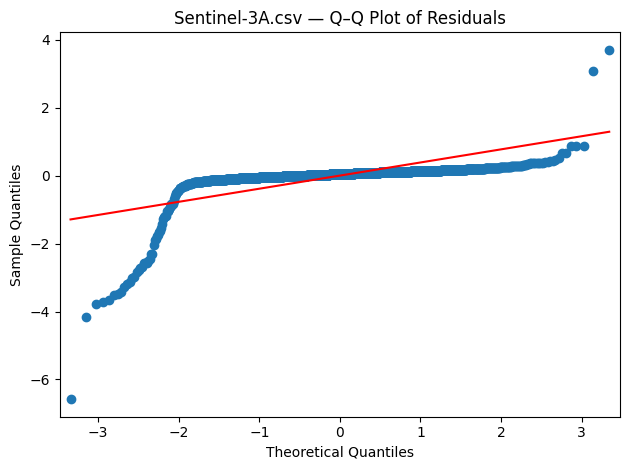


📊 Ljung–Box Test Results:
      lb_stat  lb_pvalue
10   7.215732   0.704934
20  12.917937   0.880877
30  20.117676   0.913441

✅ Conclusion: Residuals resemble white noise (no significant autocorrelation).

🔧 Auto-ARIMA selection and diagnostics for: SARAL.csv
Using d=1 for SARAL (model will difference internally).
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9967.842, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9969.870, Time=0.95 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9971.123, Time=0.98 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-9974.809, Time=1.72 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-9978.787, Time=3.16 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-9978.848, Time=2.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9969.601, Time=0.82 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9968.979, Time=2.94 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9969.282, Time=1.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-9979.018, Time=1.77 sec
 ARIMA(1,1,4

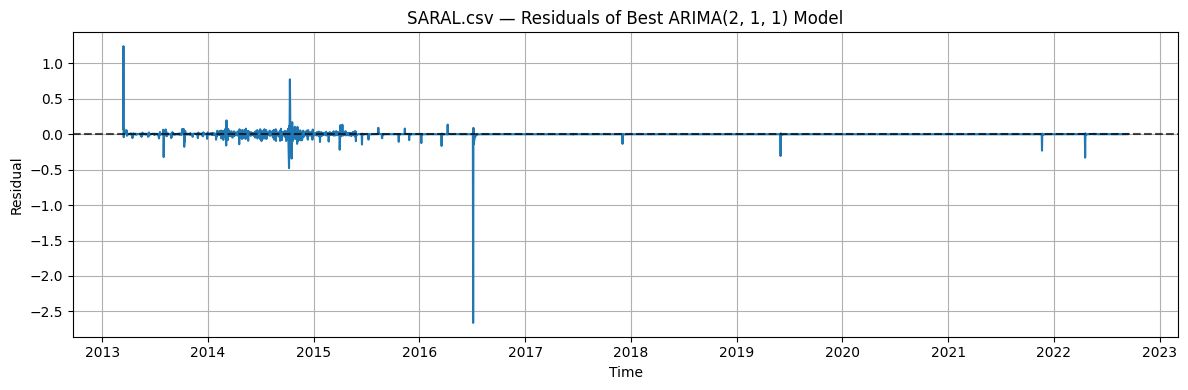

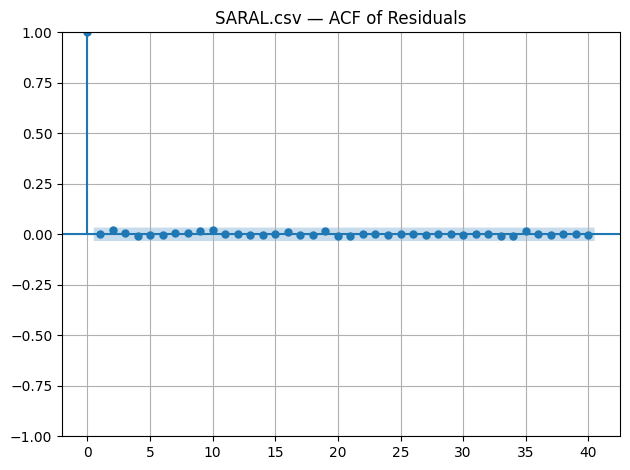

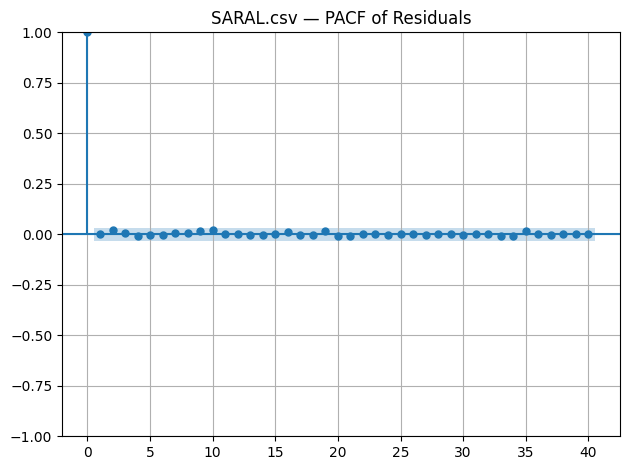

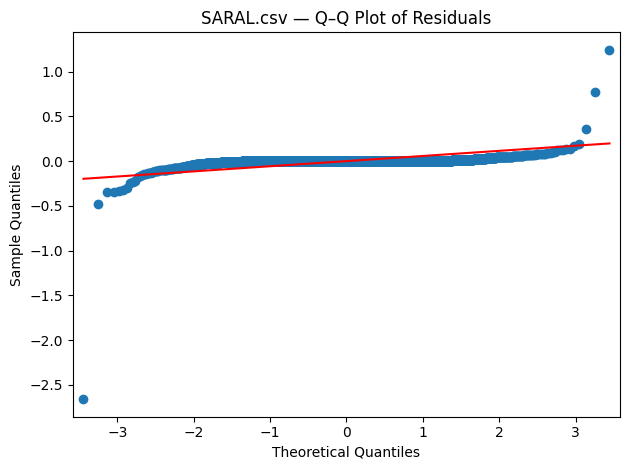


📊 Ljung–Box Test Results:
     lb_stat  lb_pvalue
10  4.713304   0.909489
20  6.271995   0.998477
30  6.897948   0.999996

✅ Conclusion: Residuals resemble white noise (no significant autocorrelation).


In [4]:
# ==== CONTINUATION: Auto-ARIMA with d=1 for SARAL, d=0 for others ====
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

arima_results = {}  # {sat_name: {"order": (p,d,q), "aic": float, "ljung_box": DataFrame, "summary": str}}

for sat_name, parts in preprocessed.items():
    print("\n" + "="*70)
    print(f"🔧 Auto-ARIMA selection and diagnostics for: {sat_name}")
    print("="*70)

    # Use standardized series for ARIMA input
    series_std = parts["bmm_standardized"].dropna()

    if len(series_std) < 30:
        print("⚠️ Not enough data points for ARIMA. Skipping.")
        continue

    # d-setting: SARAL gets d=1; others d=0 (as per request)
    d_for_arima = 1 if sat_name == "SARAL.csv" else 0
    if d_for_arima == 1:
        print("Using d=1 for SARAL (model will difference internally).")
    else:
        print("Using d=0 (assumed stationary).")

    # Auto-ARIMA full search with chosen d
    model_auto = auto_arima(
        series_std,
        start_p=0, max_p=5,
        start_q=0, max_q=5,
        d=d_for_arima,
        seasonal=False,
        stepwise=False,        # full search
        trace=True,
        suppress_warnings=True,
        error_action='ignore'
    )

    print("\n✅ Best ARIMA model selected by auto_arima:")
    print(model_auto.summary())

    # Fit best order with statsmodels for residual diagnostics
    best_params = model_auto.order
    best_model = sm.tsa.ARIMA(series_std, order=best_params).fit()

    # Residuals
    residuals = best_model.resid.dropna()

    # 1) Residual time series
    plt.figure(figsize=(12, 4))
    plt.plot(residuals)
    plt.axhline(0, color='black', linestyle='--', alpha=0.7)
    plt.title(f'{sat_name} — Residuals of Best ARIMA{best_params} Model')
    plt.xlabel('Time'); plt.ylabel('Residual'); plt.grid(True); plt.tight_layout()
    plt.show()

    # 2) ACF
    plot_acf(residuals, lags=40)
    plt.title(f'{sat_name} — ACF of Residuals')
    plt.grid(True); plt.tight_layout(); plt.show()

    # 3) PACF
    plot_pacf(residuals, lags=40, method='ywm')
    plt.title(f'{sat_name} — PACF of Residuals')
    plt.grid(True); plt.tight_layout(); plt.show()

    # 4) Q–Q plot
    qqplot(residuals, line='s')
    plt.title(f'{sat_name} — Q–Q Plot of Residuals')
    plt.tight_layout(); plt.show()

    # 5) Ljung–Box test
    ljung_box = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
    print("\n📊 Ljung–Box Test Results:")
    print(ljung_box)

    # 6) White-noise conclusion
    if (ljung_box['lb_pvalue'] > 0.05).all():
        print("\n✅ Conclusion: Residuals resemble white noise (no significant autocorrelation).")
    else:
        print("\n❌ Conclusion: Residuals show autocorrelation (not white noise). Model may be misspecified.")

    arima_results[sat_name] = {
        "order": best_params,
        "aic": float(best_model.aic),
        "ljung_box": ljung_box,
        "summary": str(model_auto.summary())
    }


# **2. Qualitatative Analysis**

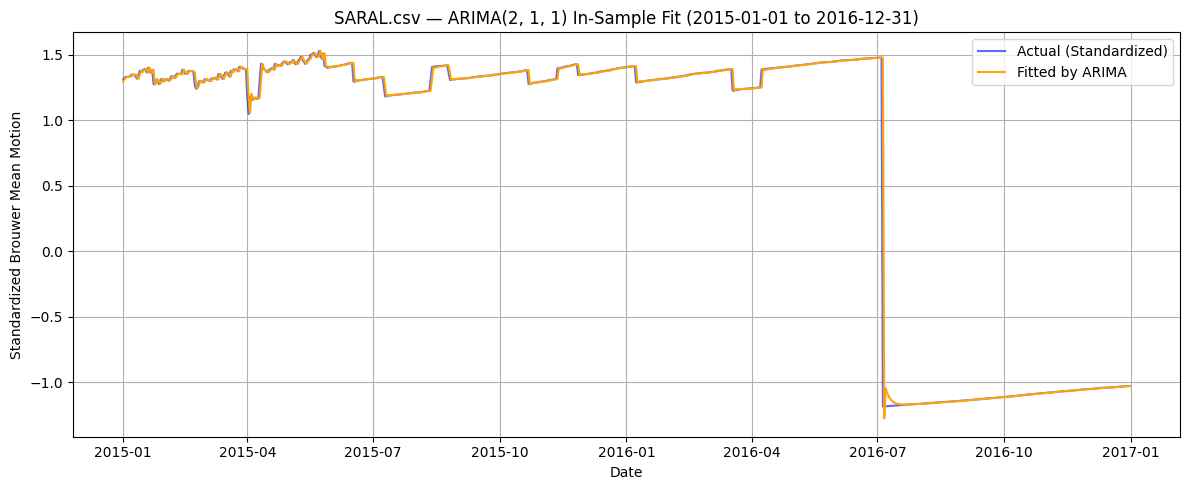

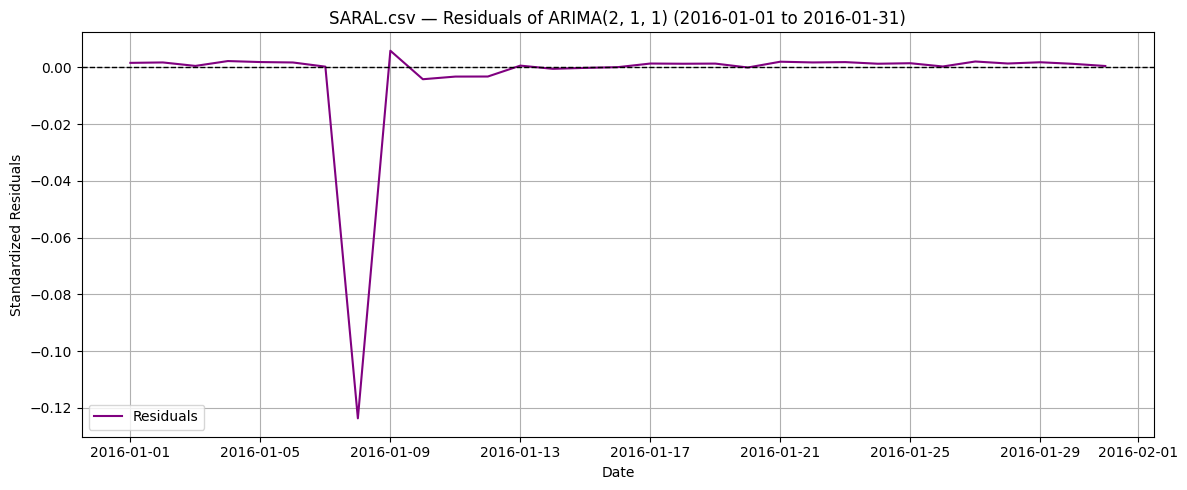

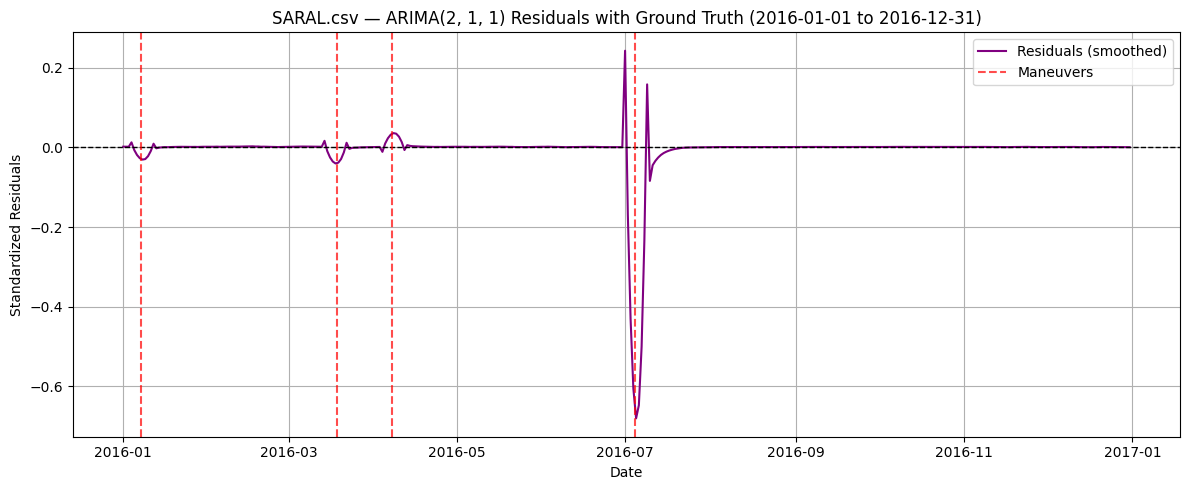

In [5]:
# ==== CONTINUATION: Single-argument plotting (only satellite name) ====
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from statsmodels.tsa.arima.model import ARIMA

# --- Hardcoded config ---
BASE = "/content"
FIT_WIN   = ("2015-01-01", "2016-12-31")
RESID_WIN = ("2016-01-01", "2016-01-31")
GT_WIN    = ("2016-01-01", "2016-12-31")
GT_MAP = {
    "Fengyun-2F.csv": "manFY2F_cleaned.xlsx",
    "Fengyun-2E.csv": "manFY2E_cleaned.xlsx",
    "Fengyun-2H.csv": "manFY2H_cleaned.xlsx",
    "Sentinel-3A.csv": "cleaned_s3aman.xlsx",  # corrected mapping
    "SARAL.csv": "cleaned_srlman.xlsx",
}

def _load_gt_timestamps(xlsx_path: str) -> pd.Series:
    df = pd.read_excel(xlsx_path)
    if {"Start Date","Start Time"}.issubset(df.columns):
        ts = pd.to_datetime(df["Start Date"].astype(str) + " " + df["Start Time"].astype(str), errors="coerce")
    elif {"Date","Time"}.issubset(df.columns):
        ts = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str), errors="coerce")
    elif "Timestamp" in df.columns:
        ts = pd.to_datetime(df["Timestamp"], errors="coerce")
    else:
        ts = None
        for col in df.columns:
            try:
                ts = pd.to_datetime(df[col], errors="raise")
                break
            except Exception:
                pass
        if ts is None:
            raise ValueError(f"Could not find datetime columns in {xlsx_path}. Columns: {list(df.columns)}")
    return ts.dropna().sort_values().reset_index(drop=True)

def plot_arima_continuation_for_sat(sat_name: str):
    """
    Makes three plots for the given satellite (no other arguments):
      1) In-sample ARIMA fit (actual vs fitted) over FIT_WIN
      2) Residuals over RESID_WIN
      3) Smoothed residuals with Ground-Truth overlays over GT_WIN

    Requires global dicts:
      - preprocessed[sat_name]["bmm_standardized"]
      - arima_results[sat_name]["order"]
    """
    # --- Checks ---
    if "preprocessed" not in globals():
        print("❌ 'preprocessed' not found. Run the preprocessing cell first.")
        return
    if "arima_results" not in globals():
        print("❌ 'arima_results' not found. Run the auto-ARIMA loop first.")
        return
    if sat_name not in preprocessed:
        print(f"❌ '{sat_name}' not found in preprocessed. Available: {list(preprocessed.keys())}")
        return
    if sat_name not in arima_results:
        print(f"❌ '{sat_name}' not in arima_results. Run the auto-ARIMA loop for this satellite.")
        return

    # --- Series + best params ---
    bmm_standardized = preprocessed[sat_name]["bmm_standardized"].dropna()
    best_params = arima_results[sat_name]["order"]

    # --- Refit best ARIMA on standardized series ---
    model_trad = ARIMA(bmm_standardized, order=best_params)
    model_trad_fit = model_trad.fit()

    # --- Plot 1: In-sample Fit (window) ---
    fitted_values = model_trad_fit.predict(start=bmm_standardized.index[0], end=bmm_standardized.index[-1])
    actual_window = bmm_standardized.loc[FIT_WIN[0]:FIT_WIN[1]]
    fitted_window = fitted_values.loc[FIT_WIN[0]:FIT_WIN[1]]

    plt.figure(figsize=(12, 5))
    plt.plot(actual_window, label='Actual (Standardized)', color='blue', alpha=0.6)
    plt.plot(fitted_window, label='Fitted by ARIMA', color='orange')
    plt.title(f'{sat_name} — ARIMA{best_params} In-Sample Fit ({FIT_WIN[0]} to {FIT_WIN[1]})')
    plt.xlabel('Date'); plt.ylabel('Standardized Brouwer Mean Motion')
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    # --- Plot 2: Residuals (window) ---
    residuals = model_trad_fit.resid.dropna()
    resid_window = residuals.loc[RESID_WIN[0]:RESID_WIN[1]]
    plt.figure(figsize=(12, 5))
    plt.plot(resid_window, label='Residuals', color='purple')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f'{sat_name} — Residuals of ARIMA{best_params} ({RESID_WIN[0]} to {RESID_WIN[1]})')
    plt.xlabel('Date'); plt.ylabel('Standardized Residuals')
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    # --- Plot 3: Smoothed Residuals + Ground Truth overlay (window) ---
    # Smooth residuals with Savitzky–Golay (valid odd window)
    win_len = 9 if len(residuals) >= 9 else (len(residuals)//2)*2 + 1
    if win_len >= 3:
        smoothed_residuals = pd.Series(
            savgol_filter(residuals, window_length=win_len, polyorder=2 if win_len > 3 else 1),
            index=residuals.index
        )
    else:
        smoothed_residuals = residuals.copy()

    gt_file = GT_MAP.get(sat_name, None)
    if gt_file is None:
        print(f"⚠️ No ground-truth mapping for {sat_name}; skipping GT overlay.")
        return
    gt_path = os.path.join(BASE, gt_file)
    if not os.path.exists(gt_path):
        print(f"⚠️ Ground-truth file not found for {sat_name}: {gt_path}")
        return

    gt_times = _load_gt_timestamps(gt_path)
    gt_in_window = gt_times[(gt_times >= pd.to_datetime(GT_WIN[0])) & (gt_times <= pd.to_datetime(GT_WIN[1]))]
    resid_window_gt = smoothed_residuals.loc[GT_WIN[0]:GT_WIN[1]]

    plt.figure(figsize=(12, 5))
    plt.plot(resid_window_gt, label='Residuals (smoothed)', color='purple')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)

    if len(gt_in_window) > 0:
        plt.axvline(x=gt_in_window.iloc[0], color='red', linestyle='--', alpha=0.7, label='Maneuvers')
        for ts in gt_in_window.iloc[1:]:
            plt.axvline(x=ts, color='red', linestyle='--', alpha=0.7)
    else:
        print(f"ℹ️ No GT maneuvers in {GT_WIN[0]} to {GT_WIN[1]} for {sat_name}.")

    plt.title(f'{sat_name} — ARIMA{best_params} Residuals with Ground Truth ({GT_WIN[0]} to {GT_WIN[1]})')
    plt.xlabel('Date'); plt.ylabel('Standardized Residuals')
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

# Example:
#plot_arima_continuation_for_sat("Fengyun-2E.csv")
# plot_arima_continuation_for_sat("Sentinel-3A.csv")
plot_arima_continuation_for_sat("SARAL.csv")


# **3. Quantitative Analysis**


🔎 Residual-transform PR evaluation — Fengyun-2F.csv


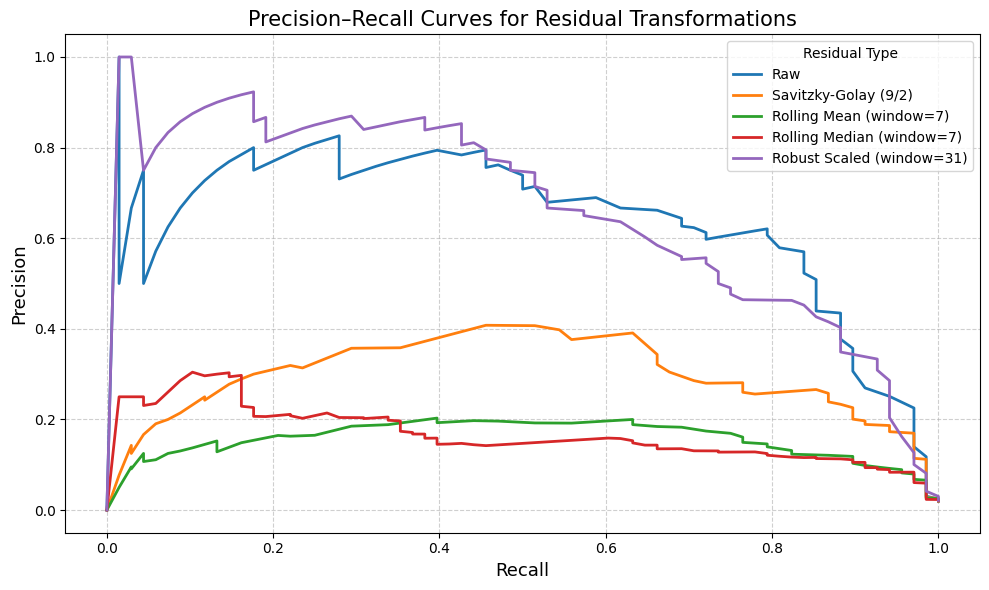


=== ARIMA Residual Evaluation Summary — Fengyun-2F.csv ===


,Satellite,Residual Type,Optimal Threshold,Precision,Recall,F1,TP,FP,FN,PR AUC
0,Fengyun-2F.csv,Raw,0.872102,0.620690,0.794118,0.696774,54,33,14,0.633365
1,Fengyun-2F.csv,Robust Scaled (window=31),12.061818,0.556818,0.720588,0.628205,49,39,19,0.659639
2,Fengyun-2F.csv,Savitzky-Golay (9/2),0.527960,0.390909,0.632353,0.483146,43,67,25,0.293598
3,Fengyun-2F.csv,Rolling Mean (window=7),0.292681,0.200000,0.632353,0.303887,43,172,25,0.154774
4,Fengyun-2F.csv,Rolling Median (window=7),0.338504,0.205357,0.338235,0.255556,23,89,45,0.165606



🔎 Residual-transform PR evaluation — Fengyun-2E.csv


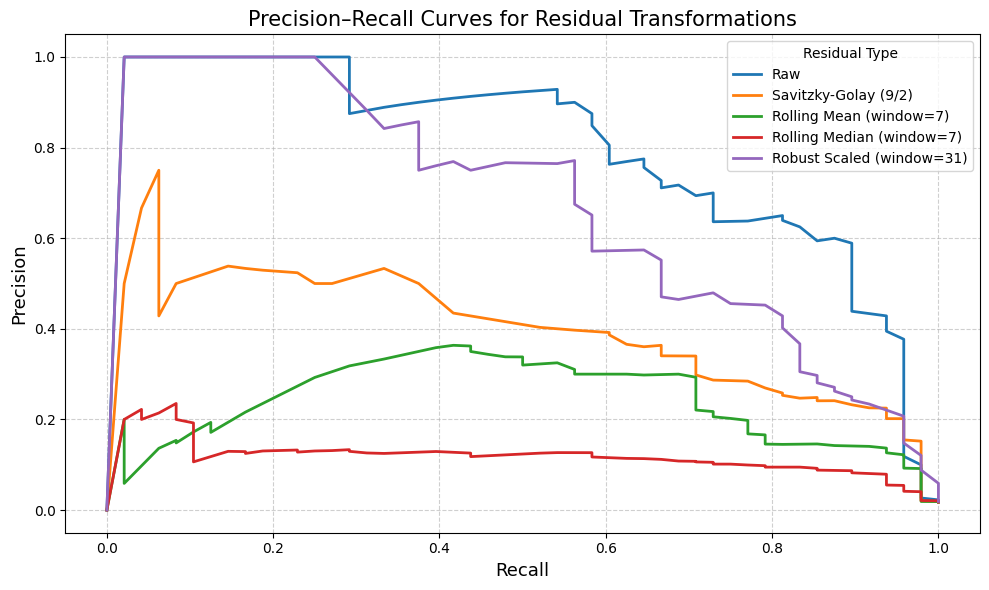


=== ARIMA Residual Evaluation Summary — Fengyun-2E.csv ===


,Satellite,Residual Type,Optimal Threshold,Precision,Recall,F1,TP,FP,FN,PR AUC
0,Fengyun-2E.csv,Raw,1.093492,0.650000,0.812500,0.722222,39,21,9,0.784910
1,Fengyun-2E.csv,Robust Scaled (window=31),22.591326,0.771429,0.562500,0.650602,27,8,21,0.668859
2,Fengyun-2E.csv,Savitzky-Golay (9/2),0.639350,0.391892,0.604167,0.475410,29,45,19,0.392276
3,Fengyun-2E.csv,Rolling Mean (window=7),0.350352,0.300000,0.687500,0.417722,33,77,15,0.237630
4,Fengyun-2E.csv,Rolling Median (window=7),0.246467,0.126697,0.583333,0.208178,28,193,20,0.118428



🔎 Residual-transform PR evaluation — Fengyun-2H.csv


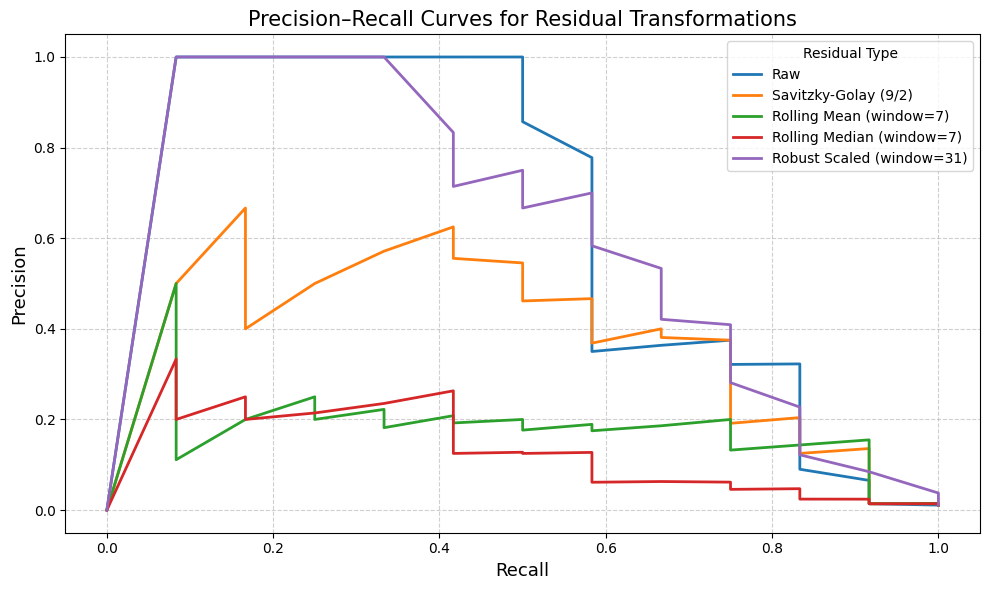


=== ARIMA Residual Evaluation Summary — Fengyun-2H.csv ===


,Satellite,Residual Type,Optimal Threshold,Precision,Recall,F1,TP,FP,FN,PR AUC
0,Fengyun-2H.csv,Raw,1.206924,0.777778,0.583333,0.666667,7,2,5,0.635712
1,Fengyun-2H.csv,Robust Scaled (window=31),25.624527,0.700000,0.583333,0.636364,7,3,5,0.607691
2,Fengyun-2H.csv,Savitzky-Golay (9/2),0.638616,0.545455,0.500000,0.521739,6,5,6,0.378059
3,Fengyun-2H.csv,Rolling Median (window=7),0.210990,0.263158,0.416667,0.322581,5,14,7,0.136395
4,Fengyun-2H.csv,Rolling Mean (window=7),0.292763,0.200000,0.750000,0.315789,9,36,3,0.152589



🔎 Residual-transform PR evaluation — Sentinel-3A.csv


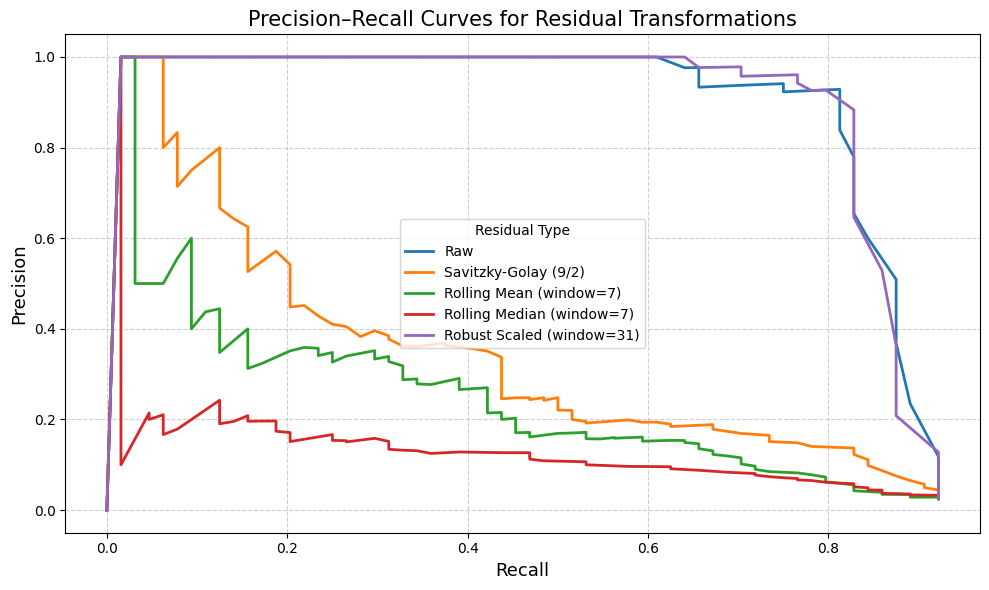


=== ARIMA Residual Evaluation Summary — Sentinel-3A.csv ===


,Satellite,Residual Type,Optimal Threshold,Precision,Recall,F1,TP,FP,FN,PR AUC
0,Sentinel-3A.csv,Raw,0.575700,0.928571,0.812500,0.866667,52,4,12,0.841212
1,Sentinel-3A.csv,Robust Scaled (window=31),6.227040,0.927273,0.796875,0.857143,51,4,13,0.843611
2,Sentinel-3A.csv,Savitzky-Golay (9/2),0.586964,0.350649,0.421875,0.382979,27,50,37,0.317466
3,Sentinel-3A.csv,Rolling Mean (window=7),0.402885,0.290698,0.390625,0.333333,25,61,39,0.223472
4,Sentinel-3A.csv,Rolling Median (window=7),0.172711,0.158333,0.296875,0.206522,19,101,45,0.128699



🔎 Residual-transform PR evaluation — SARAL.csv


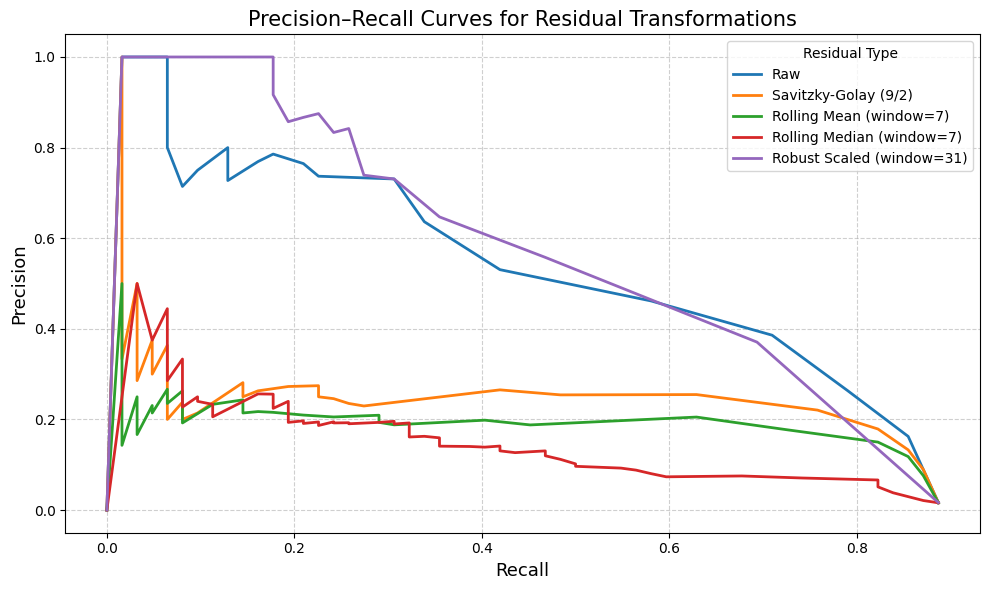


=== ARIMA Residual Evaluation Summary — SARAL.csv ===


,Satellite,Residual Type,Optimal Threshold,Precision,Recall,F1,TP,FP,FN,PR AUC
0,SARAL.csv,Raw,0.071527,0.461538,0.580645,0.514286,36,42,26,0.487834
1,SARAL.csv,Robust Scaled (window=31),12.309464,0.557692,0.467742,0.508772,29,23,33,0.518979
2,SARAL.csv,Savitzky-Golay (9/2),0.023022,0.254902,0.629032,0.362791,39,114,23,0.222575
3,SARAL.csv,Rolling Mean (window=7),0.014551,0.205263,0.629032,0.309524,39,151,23,0.171900
4,SARAL.csv,Rolling Median (window=7),0.015102,0.192308,0.322581,0.240964,20,84,42,0.128493



🏁 Global Residual-Transform PR Summary across ALL satellites (sorted by F1):


,Satellite,Residual Type,Optimal Threshold,Precision,Recall,F1,TP,FP,FN,PR AUC
0,Sentinel-3A.csv,Raw,0.575700,0.928571,0.812500,0.866667,52,4,12,0.841212
1,Sentinel-3A.csv,Robust Scaled (window=31),6.227040,0.927273,0.796875,0.857143,51,4,13,0.843611
2,Fengyun-2E.csv,Raw,1.093492,0.650000,0.812500,0.722222,39,21,9,0.784910
3,Fengyun-2F.csv,Raw,0.872102,0.620690,0.794118,0.696774,54,33,14,0.633365
4,Fengyun-2H.csv,Raw,1.206924,0.777778,0.583333,0.666667,7,2,5,0.635712
5,Fengyun-2E.csv,Robust Scaled (window=31),22.591326,0.771429,0.562500,0.650602,27,8,21,0.668859
6,Fengyun-2H.csv,Robust Scaled (window=31),25.624527,0.700000,0.583333,0.636364,7,3,5,0.607691
7,Fengyun-2F.csv,Robust Scaled (window=31),12.061818,0.556818,0.720588,0.628205,49,39,19,0.659639
8,Fengyun-2H.csv,Savitzky-Golay (9/2),0.638616,0.545455,0.500000,0.521739,6,5,6,0.378059
9,SARAL.csv,Raw,0.071527,0.461538,0.580645,0.514286,36,42,26,0.487834


In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from IPython.display import display
from statsmodels.tsa.arima.model import ARIMA

# ---- Your lists & base path ----
BASE = "/content"
orbital_elements = ['Fengyun-2F.csv','Fengyun-2E.csv','Fengyun-2H.csv','Sentinel-3A.csv','SARAL.csv']
ground_truth_manoeuvre_timestamps = ['manFY2F_cleaned.xlsx','manFY2E_cleaned.xlsx','manFY2H_cleaned.xlsx','cleaned_s3aman.xlsx','cleaned_srlman.xlsx']

# --- Utility: Robust rolling MAD (same as before) ---
def rolling_mad(x):
    med = np.median(x)
    return np.median(np.abs(x - med))

# --- Detection Function without TN (same as before) ---
def compute_prf_simple(
    residual_series: pd.Series,
    ground_truth_timestamps: pd.Series,
    threshold: float,
    matching_window_days: float = 3.0
):
    detections = residual_series[residual_series > threshold]
    detection_times = detections.index.sort_values()

    TP, FP, matched_gt = 0, 0, set()
    for det_time in detection_times:
        for i, gt_time in enumerate(ground_truth_timestamps):
            if i in matched_gt:
                continue
            if abs(det_time - gt_time) <= pd.Timedelta(days=matching_window_days):
                TP += 1
                matched_gt.add(i)
                break
        else:
            FP += 1

    FN = len(ground_truth_timestamps) - len(matched_gt)

    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1, TP, FP, FN

# ---- Global results across all satellites ----
all_sat_rows = []

# ---- Zip satellites with their GT files and loop ----
for sat_name, gt_file in zip(orbital_elements, ground_truth_manoeuvre_timestamps):
    print("\n" + "="*80)
    print(f"🔎 Residual-transform PR evaluation — {sat_name}")
    print("="*80)

    # 1) Fit the same way as your single cell (bmm_standardized + best_params must exist)
    if sat_name not in preprocessed or sat_name not in arima_results:
        print(f"❌ Missing inputs for {sat_name} (need preprocessed[...] and arima_results[...]). Skipping.")
        continue

    bmm_standardized = preprocessed[sat_name]["bmm_standardized"].dropna()
    best_params = arima_results[sat_name]["order"]
    model_trad = ARIMA(bmm_standardized, order=best_params)
    model_trad_fit = model_trad.fit()

    # 2) Residuals (same as before)
    residuals = model_trad_fit.resid

    # 3) Residual transforms (exactly the same definitions)
    resid_types = {
        "Raw": residuals.abs(),
        "Savitzky-Golay (9/2)": pd.Series(
            savgol_filter(residuals, window_length=9, polyorder=2),
            index=residuals.index
        ).abs(),
        "Rolling Mean (window=7)": residuals.rolling(window=7, center=True, min_periods=1).mean().abs(),
        "Rolling Median (window=7)": residuals.rolling(window=7, center=True, min_periods=1).median().abs(),
        "Robust Scaled (window=31)": (
            ((residuals - residuals.rolling(window=31, center=True, min_periods=1).median()) /
             (residuals.rolling(window=31, center=True, min_periods=1).apply(rolling_mad, raw=True) + 1e-8)).abs()
        ),
    }

    # 4) Load GT and build Maneuver_Timestamp exactly like your snippet
    gt_path = os.path.join(BASE, gt_file)
    truth_df = pd.read_excel(gt_path)
    truth_df["Maneuver_Timestamp"] = pd.to_datetime(
        truth_df["Start Date"].astype(str) + " " + truth_df["Start Time"].astype(str)
    )
    series_ground_truth_manoeuvre_timestamps = truth_df["Maneuver_Timestamp"]

    # 5) Evaluation loop (identical thresholding and PR/AUC computation)
    summary_rows = []
    resid_metrics_dfs = {}
    matching_window_days = 3.0

    plt.figure(figsize=(10, 6))
    for name, abs_resid in resid_types.items():
        abs_resid_clean = abs_resid[abs_resid > abs_resid.quantile(0.01)]
        thresholds = np.linspace(abs_resid_clean.min(), abs_resid_clean.max(), 150)

        pr_points, metrics = [], []
        for threshold in thresholds:
            precision, recall, f1, TP, FP, FN = compute_prf_simple(
                abs_resid,
                series_ground_truth_manoeuvre_timestamps,
                threshold,
                matching_window_days=matching_window_days
            )
            pr_points.append((recall, precision))
            metrics.append((threshold, precision, recall, f1, TP, FP, FN))

        metrics_df = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1", "TP", "FP", "FN"])
        resid_metrics_dfs[name] = metrics_df.copy()

        best_idx = metrics_df["F1"].idxmax()
        best_row = metrics_df.loc[best_idx]

        pr_points_arr = np.array(pr_points)
        sorted_idx = np.argsort(pr_points_arr[:, 0])  # sort by recall
        auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])  # PR AUC

        # add satellite name to row
        row = {
            "Satellite": sat_name,
            "Residual Type": name,
            "Optimal Threshold": best_row["Threshold"],
            "Precision": best_row["Precision"],
            "Recall": best_row["Recall"],
            "F1": best_row["F1"],
            "TP": int(best_row["TP"]),
            "FP": int(best_row["FP"]),
            "FN": int(best_row["FN"]),
            "PR AUC": auc_pr
        }
        summary_rows.append(row)

        plt.plot(pr_points_arr[:, 0], pr_points_arr[:, 1], label=f"{name}", linewidth=2)

    # 6) Plot per-satellite PR curves (same labels/styles)
    plt.xlabel("Recall", fontsize=13)
    plt.ylabel("Precision", fontsize=13)
    plt.title("Precision–Recall Curves for Residual Transformations", fontsize=15)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Residual Type", fontsize=10)
    plt.tight_layout()
    plt.show()

    # 7) Per-satellite table (same format) + collect into global list
    summary_df = pd.DataFrame(summary_rows).sort_values("F1", ascending=False).reset_index(drop=True)
    print(f"\n=== ARIMA Residual Evaluation Summary — {sat_name} ===")
    display(summary_df)

    all_sat_rows.extend(summary_rows)

# ---- FINAL global table: all satellites together, sorted by F1 ----
all_sat_summary_df = pd.DataFrame(all_sat_rows).sort_values("F1", ascending=False).reset_index(drop=True)
print("\n🏁 Global Residual-Transform PR Summary across ALL satellites (sorted by F1):")
display(all_sat_summary_df)
# Optionally save:
# all_sat_summary_df.to_csv("/content/all_sat_residual_PR_summary.csv", index=False)
